<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/no_use_Acc_Focal_Loss_DenseNet121_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [2]:
!nvidia-smi

Sat May 30 16:08:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip install runai

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [5]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import models
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
import runai.ga.keras

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# **Clone Data**

In [6]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 50.54 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7
STEPS = 16

LR = 3e-5 # Learning rate

# **Prepare Data**

In [0]:
data=pd.read_csv('/content/ham10000-with-one-image-folder/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [9]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


### **Split Data**

In [0]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [0]:
train = pd.concat([X_train,y_train],axis=1)
val = pd.concat([X_val,y_val],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train['dx'])
name_as_indexes_train = encoder.transform(train['dx']) 
train['label'] = name_as_indexes_train

In [0]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_val = encoder.transform(val['dx']) 
val['label'] = name_as_indexes_val

In [0]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

### **Data Augmentation**

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
test_generator=ImageDataGenerator(rescale = 1./255)
test_generator=ImageDataGenerator(rescale = 1./255)

In [16]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                                shuffle=True,batch_size=32,class_mode="categorical",target_size=(IMG_WIDTH,IMG_HEIGHT))

val_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=True,batch_size=32,class_mode='categorical',target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 6309 validated image filenames belonging to 7 classes.
Found 2704 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames.


# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=0.5):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [18]:
ga_optimizer = runai.ga.keras.optimizers.Optimizer(Adam(LR), steps=STEPS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [30-05-2020 16:11:04.059] [138] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


# Class Weight

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(name_as_indexes_train), name_as_indexes_train)

In [20]:
class_weights

array([ 4.76870748,  2.82534707,  1.32542017, 11.40867993,  1.28939301,
        0.21181803, 10.24188312])

In [0]:
train_class_weight_dict = { i : class_weights[i] for i in range(0, len(class_weights) ) }

In [22]:
train_class_weight_dict

{0: 4.7687074829931975,
 1: 2.825347066726377,
 2: 1.3254201680672268,
 3: 11.408679927667269,
 4: 1.2893930104230533,
 5: 0.21181802920933357,
 6: 10.241883116883116}

# **Build Model**

### **Use DenseNet121 + fine tuning**

In [0]:
def build_model():
  base_model = keras.applications.DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = BatchNormalization()(fc_layer)
  dropout_layer = Dropout(0.25)(bn_layer)
  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(dropout_layer)
  model = Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=Adam(LR), loss=[focal_loss(alpha=0.5, gamma=2)], metrics=['accuracy'])
  return model

In [24]:
model = build_model()



29089792/29084464 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### **Architecture**

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### **Callbacks**

In [0]:
model_path = '/content/Acc_Focal-Loss_ResNet50_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=1-7)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [34]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=EPOCHS,
                            class_weight=train_class_weight_dict,
                            callbacks=cb_list)

Epoch 1/100
197/197 [==============================] - 148s 752ms/step - loss: 0.1743 - accuracy: 0.6474 - val_loss: 0.1543 - val_accuracy: 0.7068

Epoch 00001: val_loss did not improve from 0.21513
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


197/197 [==============================] - 151s 765ms/step - loss: 0.1686 - accuracy: 0.6635 - val_loss: 0.1576 - val_accuracy: 0.7156

Epoch 00002: val_loss did not improve from 0.21513
Epoch 3/100
197/197 [==============================] - 150s 759ms/step - loss: 0.1609 - accuracy: 0.6814 - val_loss: 0.1441 - val_accuracy: 0.7156

Epoch 00003: val_loss did not improve from 0.21513
Epoch 4/100
197/197 [==============================] - 149s 755ms/step - loss: 0.1566 - accuracy: 0.6825 - val_loss: 0.1422 - val_accuracy: 0.7257

Epoch 00004: val_loss did not improve from 0.21513
Epoch 5/100
197/197 [==============================] - 148s 753ms/step - loss: 0.1509 - accuracy: 0.6936 - val_loss: 0.1705 - val_accuracy: 0.7216

Epoch 00005: val_loss did not improve from 0.21513
Epoch 6/100
197/197 [==============================] - 148s 750ms/step - loss: 0.1478 - accuracy: 0.7043 - val_loss: 0.1390 - val_accuracy: 0.7436

Epoch 00006: val_loss did not improve from 0.21513
Epoch 7/100
197/1

# **Accuracy and Loss Graph**

### **Accuracy**

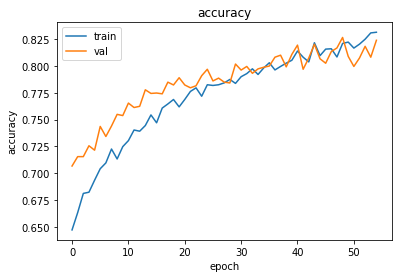

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

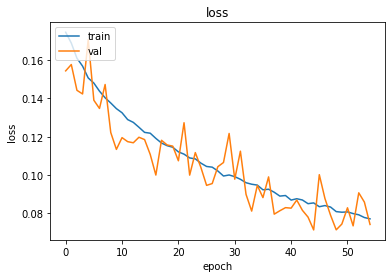

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [37]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1002/1002 [==============================] - 29s 29ms/step


### **Classification Report**

In [38]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(name_as_indexes_test, y_pred))
print('Classification Report')
classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(name_as_indexes_test, y_pred, target_names=classes_names))

Confusion Matrix
[[  8   3  11   1  13   5   0]
 [  2  27   6   0   5   7   0]
 [  0   4  82   0  13  26   0]
 [  0   1   2   4   2   6   0]
 [  1   0  13   0  63  32   1]
 [  0   0  19   0  32 598   0]
 [  0   0   0   0   0   0  15]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.73      0.20      0.31        41
         bcc       0.77      0.57      0.66        47
         bkl       0.62      0.66      0.64       125
          df       0.80      0.27      0.40        15
         mel       0.49      0.57      0.53       110
          nv       0.89      0.92      0.90       649
        vasc       0.94      1.00      0.97        15

    accuracy                           0.80      1002
   macro avg       0.75      0.60      0.63      1002
weighted avg       0.80      0.80      0.79      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[  8   3  11   1  13   5   0]
 [  2  27   6   0   5   7   0]
 [  0   4  82   0  13  26   0]
 [  0   1   2   4   2   6   0]
 [  1   0  13   0  63  32   1]
 [  0   0  19   0  32 598   0]
 [  0   0   0   0   0   0  15]]


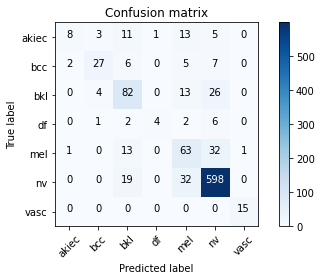

In [39]:
cm = (confusion_matrix(name_as_indexes_test, y_pred))

plot_confusion_matrix(cm, classes_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [42]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.7273
specificity: 0.9310


# **Grad-CAM**

In [0]:
last_conv2d = 'conv5_block16_2_conv'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.817
	bkl            	(2)	with probability 0.055
	akiec          	(0)	with probability 0.050
	bcc            	(1)	with probability 0.032
	df             	(3)	with probability 0.021
Explanation for 'mel'


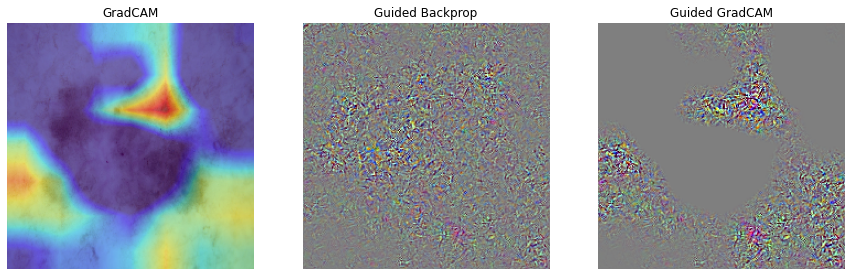

In [45]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.652
	mel            	(4)	with probability 0.179
	bkl            	(2)	with probability 0.075
	akiec          	(0)	with probability 0.033
	bcc            	(1)	with probability 0.031
Explanation for 'nv'


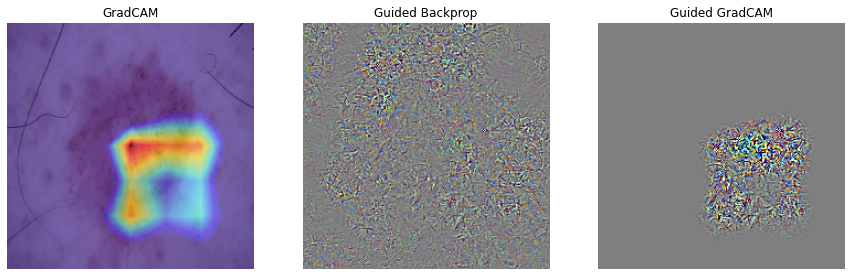

In [47]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.662
	bkl            	(2)	with probability 0.180
	nv             	(5)	with probability 0.097
	akiec          	(0)	with probability 0.024
	df             	(3)	with probability 0.014
Explanation for 'mel'


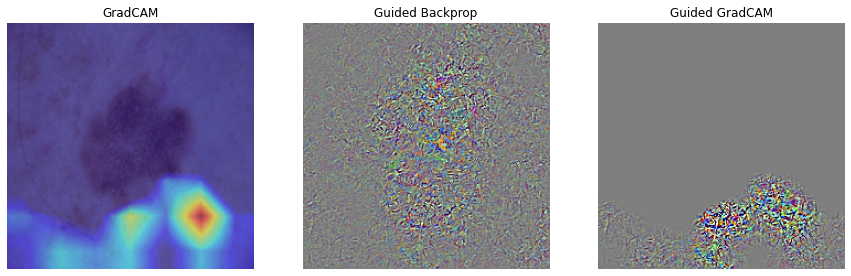

In [49]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.459
	nv             	(5)	with probability 0.305
	df             	(3)	with probability 0.065
	bkl            	(2)	with probability 0.064
	akiec          	(0)	with probability 0.058
Explanation for 'mel'


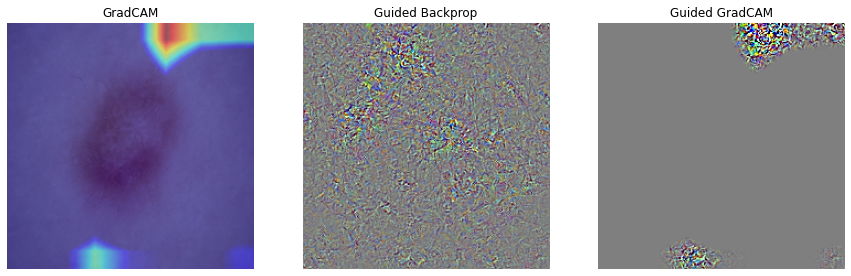

In [51]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.771
	nv             	(5)	with probability 0.120
	bkl            	(2)	with probability 0.053
	akiec          	(0)	with probability 0.030
	bcc            	(1)	with probability 0.013
Explanation for 'mel'


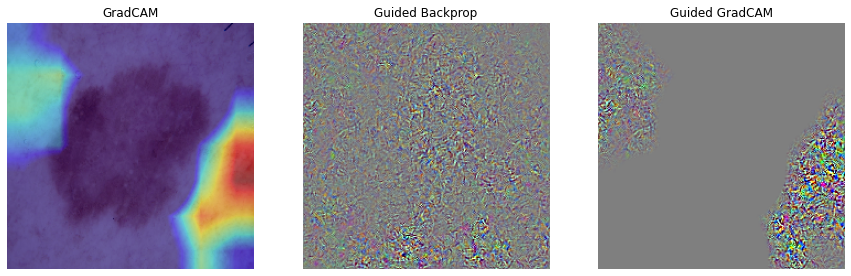

In [53]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 0.427
	mel            	(4)	with probability 0.390
	bkl            	(2)	with probability 0.081
	vasc           	(6)	with probability 0.034
	akiec          	(0)	with probability 0.026
Explanation for 'nv'


/content/ham10000_utils_functions.py:136: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


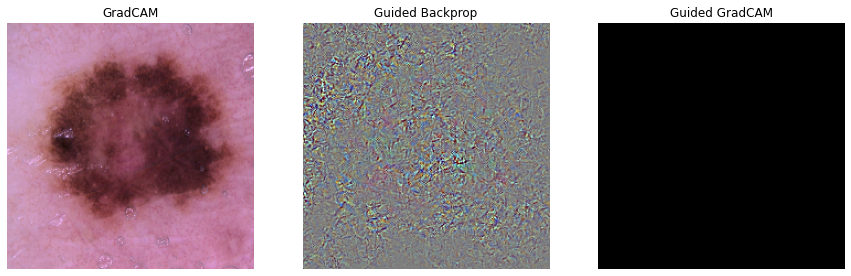

In [55]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 0.828
	bcc            	(1)	with probability 0.075
	df             	(3)	with probability 0.040
	akiec          	(0)	with probability 0.034
	bkl            	(2)	with probability 0.010
Explanation for 'vasc'


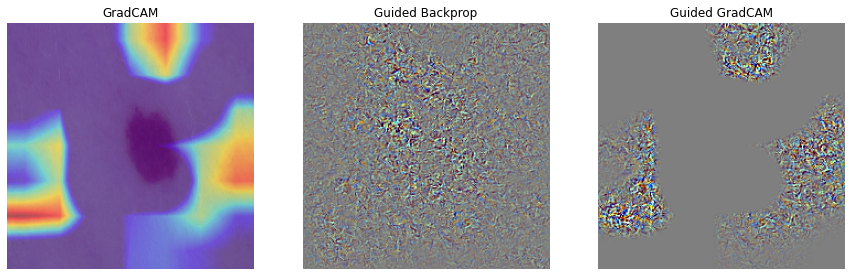

In [57]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [59]:
files.download('/content/Focal-Loss_ResNet50_model.h5')
files.download('/content/Focal-Loss_ResNet50_weights.h5')

FileNotFoundError: ignored